# Исследование факторов, связанных с показателями смертности от разных причин

In [240]:
import sys
# Добавим папку проекта в список системных директорий, чтобы Python видел путь к папке utils
sys.path.append('..')

In [241]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from utils.constants import (
    F, 
    FieldSemanticCategory,
)
from utils.graphics import (
    display_clusters_profiles,
    dislay_partial_correlation_matrix,
)
from utils.display_content import (
    dislay_some_fields_description,
)
from utils.prepare_data import (
    get_fields_by_semantic_category,
    move_column_to_end_table,
    get_temp_rename_dict,
    add_child_mortality_data,
    get_scaled_data,
)

from warnings import simplefilter
simplefilter('ignore')

In [242]:
# Загрузим таблицу
data_source = pd.read_csv('../data/cumulative_life_expectancy_prepared.csv')

data_source.head()

,ParentLocationCode,ParentLocation,SpatialDimValueCode,Location,Period,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality117,...,Sanitation,DrinkingWater,HealthCareCosts,HealthCareCostsGdp,HealthCareCostsPerCapita,GdpPerCapita,Population,Schooling,ClusterKMeans,LifeExpectancy
0,AFR,Africa,AGO,Angola,2000,34.56,0.01331,0.859921,30.5,0.028126,...,27.56,41.14,2.74,1.11,7.66,563.733796,16194869.0,5.027188,1,49.37
1,AFR,Africa,AGO,Angola,2001,33.86,0.01310,0.799641,29.7,0.027503,...,28.99,42.25,5.97,2.05,13.35,533.586202,16747208.0,5.092250,1,50.06
2,AFR,Africa,AGO,Angola,2002,32.51,0.01288,0.758272,29.4,0.027049,...,30.42,43.38,4.19,1.31,11.54,882.147847,17327699.0,5.157312,1,51.06
3,AFR,Africa,AGO,Angola,2003,32.16,0.01265,0.676496,29.3,0.026962,...,31.86,44.36,4.26,1.47,14.55,992.698979,17943712.0,5.222375,1,51.74
4,AFR,Africa,AGO,Angola,2004,32.24,0.01229,0.594192,29.0,0.026300,...,33.29,45.35,5.66,1.69,21.36,1266.210864,18600423.0,5.287437,1,52.36


Оставим в таблице только те поля, которые будем рассматривать.

In [243]:
# Поля с данными о причинах смертности взрослых
adult_mortality_fields = get_fields_by_semantic_category(
    FieldSemanticCategory.ADULT_MORTALITY.value
)

# Оставим в таблице только рассматриваемые поля
field_names = [F.Period.value, F.SpatialDimValueCode.value] + \
    adult_mortality_fields + \
    [F.ClusterKMeans.value, F.LifeExpectancy.value]

data = data_source[field_names]

data.head()

,Period,SpatialDimValueCode,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality061,AdultNcdMortality080,AdultNcdMortality110,AdultNcdMortality117,AdultNcdMortalitySum,PoisoningMortality,SuicideMortality,ClusterKMeans,LifeExpectancy
0,2000,AGO,34.56,0.01331,0.859921,30.5,0.035369,0.019216,0.127139,0.028126,0.209850,0.00361,0.01756,1,49.37
1,2001,AGO,33.86,0.01310,0.799641,29.7,0.034668,0.019149,0.126128,0.027503,0.207450,0.00353,0.01746,1,50.06
2,2002,AGO,32.51,0.01288,0.758272,29.4,0.034367,0.018993,0.124933,0.027049,0.205342,0.00361,0.01724,1,51.06
3,2003,AGO,32.16,0.01265,0.676496,29.3,0.034469,0.019188,0.125342,0.026962,0.205961,0.00372,0.01747,1,51.74
4,2004,AGO,32.24,0.01229,0.594192,29.0,0.034687,0.019080,0.123723,0.026300,0.203791,0.00371,0.01719,1,52.36


In [244]:
dislay_some_fields_description(field_names)

**Описание полей:**

- `Period` - Год

- `SpatialDimValueCode` - Код страны

- `AdultMortality` - Смертность среди взрослого населения от 15 до 60 лет (в % от численности населения)

- `Homicides` - Оценка уровня убийств (%)

- `MaternalMortality` - Коэффициент материнской смертности (%)

- `AdultNcdMortality` - Вероятность (в %) смерти в возрасте от 30 до 70 лет от сердечно-сосудистых заболеваний, рака, диабета или хронических респираторных заболеваний

- `AdultNcdMortality061` - Смертность взрослых от неинфекционных заболеваний (%). Злокачественные новообразования

- `AdultNcdMortality080` - Смертность взрослых от неинфекционных заболеваний (%). Сахарный диабет

- `AdultNcdMortality110` - Смертность взрослых от неинфекционных заболеваний (%). Сердечно-сосудистые заболевания

- `AdultNcdMortality117` - Смертность взрослых от неинфекционных заболеваний (%). Респираторные заболевания

- `AdultNcdMortalitySum` - Сумма причин (в %) смертности взрослых от неинфекционных заболеваний.

- `PoisoningMortality` - Уровень смертности от непреднамеренного отравления (%)

- `SuicideMortality` - Стандартизированные по возрасту показатели самоубийств (%)

- `ClusterKMeans` - Кластер страны, определенный с помощью k-means

- `LifeExpectancy` - Ожидаемая продоложительность жизни

## Сравнение средних показателей причин смертности взрослых в кластерах стран

In [245]:
# Для построения графика масштабируем данные
adult_mortality_scaled_data = get_scaled_data(data)

# Для удобства просмотра графика временно переименуем поля на русский
rename_dict = get_temp_rename_dict(adult_mortality_scaled_data)

# Построим полярную диаграмму
display_clusters_profiles(    
    adult_mortality_scaled_data \
        # Уберем эти 2 признака, так как в них не выделены отдельные причины
        .drop(columns=[F.AdultNcdMortality.value, F.AdultMortality.value]) \
        .groupby(F.ClusterKMeans.value) \
        .agg('mean') \
        .rename(columns=rename_dict),
    title='Сравнение средних показателей причин смертности взрослых в кластерах стран',
    should_display_table=False,
    is_custom_size=False,
)

**В странах с меньшей продолжительностью жизни (кластер 1)** более высокие значения имеют показатели:
- Коэффициент материнской смертности
- Уровень смертности от непреднамеренного отравления 

Незначительно более высокие значения у показателей:
- Оценка уровня убийств
- Стандартизированные по возрасту показатели самоубийств 

**В странах с большей продолжительностью жизни (кластер 0)** более высокие значения имеют показатели:
- Смертность взрослых от всех рассматриваемых неинфекционных заболеваний.

### Сравнение показателей смертности от неинфекционных заболеваний

In [246]:
# Возьмем среднее по показателям смертности от неинфекционных заболеваний по кластерам стран
# И также временно переименуем столбцы для удобства просмотра графика
adult_ncd_data = data[[
    F.AdultNcdMortality061.value,
    F.AdultNcdMortality080.value,
    F.AdultNcdMortality110.value,
    F.AdultNcdMortality117.value,
    F.AdultNcdMortalitySum.value,
    F.ClusterKMeans.value,
]].groupby(F.ClusterKMeans.value) \
    .agg('mean') \
    .reset_index() \
    .rename(columns={'index': F.ClusterKMeans.value}) \
    .rename(columns=rename_dict)
    
adult_ncd_data

,ClusterKMeans,В-061. Злокач. новообр.,В-080. Сахарный диабет,В-110. Сердечно-сосуд. заб.,В-117. Респират. заб.,В. Сумма смертности от НЗ
0,0,0.149858,0.033036,0.308953,0.037359,0.529206
1,1,0.048952,0.026075,0.142700,0.030924,0.248651


In [247]:
# Для построения графика переведем столбцы в строки
adult_ncd_data = adult_ncd_data.melt(
    id_vars=[F.ClusterKMeans.value], 
    var_name='AdultNcdMortalytyCause', 
    value_name='Mean'
)

adult_ncd_data

,ClusterKMeans,AdultNcdMortalytyCause,Mean
0,0,В-061. Злокач. новообр.,0.149858
1,1,В-061. Злокач. новообр.,0.048952
2,0,В-080. Сахарный диабет,0.033036
3,1,В-080. Сахарный диабет,0.026075
4,0,В-110. Сердечно-сосуд. заб.,0.308953
5,1,В-110. Сердечно-сосуд. заб.,0.142700
6,0,В-117. Респират. заб.,0.037359
7,1,В-117. Респират. заб.,0.030924
8,0,В. Сумма смертности от НЗ,0.529206
9,1,В. Сумма смертности от НЗ,0.248651


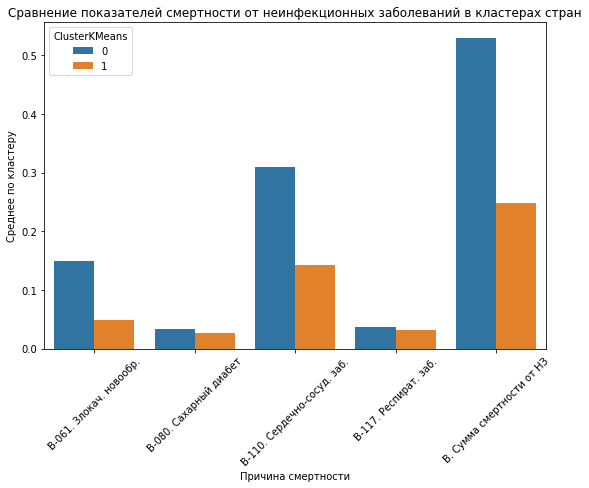

In [248]:
# Построим график
fig = plt.figure(figsize=(9, 6))
barplot = sns.barplot(
    data=adult_ncd_data,
    x='AdultNcdMortalytyCause',
    y='Mean',
    hue=F.ClusterKMeans.value,
)
barplot.set_xlabel('Причина смертности')
barplot.set_ylabel('Среднее по кластеру')
barplot.tick_params(axis='x', rotation=45)
barplot.set_title('Сравнение показателей смертности от неинфекционных заболеваний в кластерах стран');

По всем рассмотренным причинам смертность в странах кластера 0 с большей продолжительностью жизни больше.\
Как мы и видели на предыдущем графике.\
Наибольшее значение у показателя смертности от сердечно-сосудистых заболеваний.

## Сравнение средних показателей причин детской смертности в кластерах стран

Добавим в таблицу данные о детской смертности.\
Поскольку данные эти есть только до 2017 года, после добавления в таблице остануться данные за 2000-2017 гг.

In [249]:
# Добавим данные о детской смертности
cumulative_data = add_child_mortality_data(data)

# Переставим столбец с таргетом в конец таблицы
cumulative_data = move_column_to_end_table(cumulative_data, F.LifeExpectancy.value)

cumulative_data.head()

,Period,SpatialDimValueCode,AdultMortality,Homicides,MaternalMortality,AdultNcdMortality,AdultNcdMortality061,AdultNcdMortality080,AdultNcdMortality110,AdultNcdMortality117,...,ChildUnder5Mortality12,ChildUnder5Mortality3,ChildUnder5Mortality11,ChildUnder5Mortality13,ChildUnder5Mortality17,ChildUnder5Mortality9,ChildUnder5Mortality16,ChildUnder5Mortality15,ChildUnder5Mortality10,LifeExpectancy
0,2000,AGO,34.56,0.01331,0.859921,30.5,0.035369,0.019216,0.127139,0.028126,...,0.029,0.20,0.095,0.091,0.036,0.21,0.027,0.038,0.087,49.37
1,2001,AGO,33.86,0.01310,0.799641,29.7,0.034668,0.019149,0.126128,0.027503,...,0.030,0.19,0.093,0.090,0.035,0.20,0.027,0.037,0.087,50.06
2,2002,AGO,32.51,0.01288,0.758272,29.4,0.034367,0.018993,0.124933,0.027049,...,0.032,0.18,0.093,0.092,0.037,0.21,0.028,0.037,0.087,51.06
3,2003,AGO,32.16,0.01265,0.676496,29.3,0.034469,0.019188,0.125342,0.026962,...,0.034,0.18,0.099,0.097,0.039,0.21,0.029,0.039,0.091,51.74
4,2004,AGO,32.24,0.01229,0.594192,29.0,0.034687,0.019080,0.123723,0.026300,...,0.036,0.18,0.100,0.100,0.041,0.22,0.030,0.040,0.094,52.36


In [250]:
# Имена столбцов с данными о детской смертности
child_mortality_fields = get_fields_by_semantic_category(FieldSemanticCategory.CHILD_MORTALITY.value)

# Выведем описание полей с причинами детской смертности
dislay_some_fields_description(
    child_mortality_fields,
    title='Факторы с причинами детской смертности',
)

**Факторы с причинами детской смертности:**

- `ChildUnder5Mortality2` - Распределение причин смерти среди детей в возрасте до 5 лет (%). ВИЧ/СПИД.

- `ChildUnder5Mortality3` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Диарейные заболевания.

- `ChildUnder5Mortality5` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Столбняк.

- `ChildUnder5Mortality6` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Корь.

- `ChildUnder5Mortality7` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Менингит/энцефалит.

- `ChildUnder5Mortality8` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Малярия.

- `ChildUnder5Mortality9` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Острые инфекции нижних дыхательных путей.

- `ChildUnder5Mortality10` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Недоношенность.

- `ChildUnder5Mortality11` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Родовая асфиксия и родовая травма.

- `ChildUnder5Mortality12` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Сепсис и другие инфекционные состояния новорожденных.

- `ChildUnder5Mortality13` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Другие инфекционные, перинатальные и алиментарные состояния.

- `ChildUnder5Mortality15` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Врожденные аномалии.

- `ChildUnder5Mortality16` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Другие неинфекционные заболевания.

- `ChildUnder5Mortality17` - Распределение причин смерти среди детей в возрасте до 5 лет (%). Травмы.

In [251]:
# Оставим в таблице только рассматриваемые столбцы
child_data = cumulative_data[child_mortality_fields + [F.ClusterKMeans.value]]

# Для удобства просмотра графика временно переименуем поля на русский
rename_dict = get_temp_rename_dict(child_data)

# Возьмем среднее по показателям детской смертности по кластерам стран
# И также временно переименуем столбцы для удобства просмотра графика
child_data = child_data \
    .groupby(F.ClusterKMeans.value) \
    .agg('mean') \
    .reset_index() \
    .rename(columns={'index': F.ClusterKMeans.value}) \
    .rename(columns=rename_dict)

# Для построения графика переведем столбцы в строки
child_data = child_data.melt(
    id_vars=[F.ClusterKMeans.value], 
    var_name='ChildMortalytyCause', 
    value_name='Mean'
)

child_data.head()

,ClusterKMeans,ChildMortalytyCause,Mean
0,0,Д-2. ВИЧ/СПИД,0.003919
1,1,Д-2. ВИЧ/СПИД,0.045813
2,0,Д-3. Диарея,0.026474
3,1,Д-3. Диарея,0.101720
4,0,Д-5. Столбняк,0.001059


Для наглядности выведем графики с полученными данными, отсортированными отдельно для каждого кластера.

In [252]:
def display_child_data_by_cluster(cluster: int) -> None:
    """Выводит столбчатую диаграмму с показателями причин детской смертности в кластерах

    Args:
        cluster (int): номер кластера, для которого сортируем значения
    """
    # Отсортируем названия причин по убыванию их значений в кластере
    mask = child_data[F.ClusterKMeans.value] == cluster
    order = list(
        child_data[mask]
        .sort_values(by=['Mean'], ascending=False)['ChildMortalytyCause'].values
    )

    # Построим график
    fig = plt.figure(figsize=(14, 6))
    barplot = sns.barplot(
        data=child_data,
        x='ChildMortalytyCause',
        y='Mean',
        hue=F.ClusterKMeans.value,
        order=order,
    )
    barplot.set_xlabel('Причина смертности')
    barplot.set_ylabel('Среднее по кластеру')
    barplot.tick_params(axis='x', rotation=90)
    barplot.grid()
    
    title = 'Сравнение показателей детской смертности в кластерах стран '
    title += f'(по убыванию значений в кластере {cluster})'
    barplot.set_title(title);

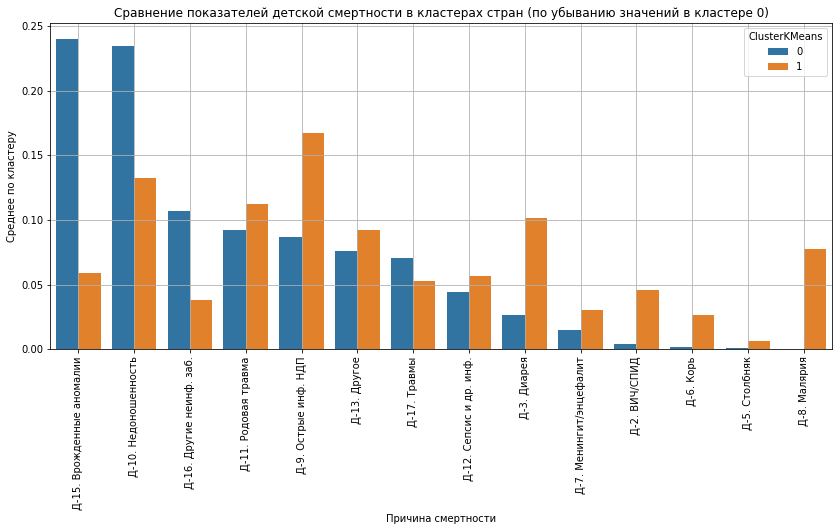

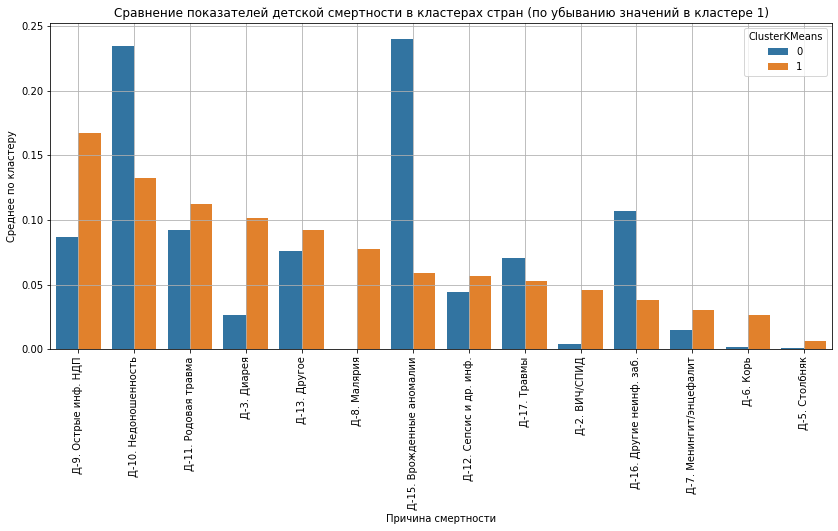

In [253]:
display_child_data_by_cluster(0)
display_child_data_by_cluster(1)

Для **кластера 0** видим более высокую смертность от неинфекционных заболеваний,\
так же, как и для причин смертности взрослых в кластере 0 выше.\
Наибольшая смертность от врожденных аномалий и недоношенности.

Для **кластера 1** более высокая смертность от инфекционных заболеваний.\
Наибольшая смертность от острых инфекций нижних дыхательных путей, недоношенности, родовой травмы и диареи.

## Исследование корреляции между причинами взрослой и детской смертности

Будем рассматривать корреляцию отдельно по двум кластерам стран.

In [254]:
# Данные стран с кластером 0 (страны с более благоприятными условиями и большей продолжительностью жизни)
cluster_0_data = cumulative_data[cumulative_data[F.ClusterKMeans.value] == 0]

# Данные стран с кластером 1 (страны с менее благоприятными условиями и меньшей продолжительностью жизни)
cluster_1_data = cumulative_data[cumulative_data[F.ClusterKMeans.value] == 1]

### Корреляция для стран из кластера 0 (с более благоприятными условиями и большей продолжительностью жизни)

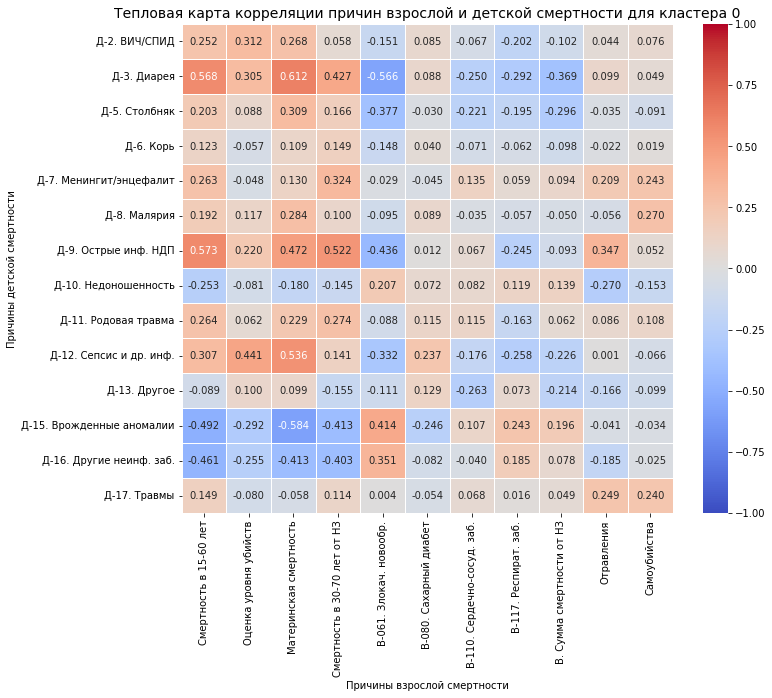

In [255]:
# Построим матрицу корреляции
dislay_partial_correlation_matrix(
    cluster_0_data, # данные стран кластера 0
    columns_features=adult_mortality_fields, # столбцы с причинами взрослой смертности
    rows_features=child_mortality_fields, # строки с причинами детской смертности
    figsize=(11, 9),
    xlabel='Причины взрослой смертности',
    ylabel='Причины детской смертности',
    title='Тепловая карта корреляции причин взрослой и детской смертности для кластера 0',
)

Для наглядности оставим в таблице признаки с наибольшей корреляцией.

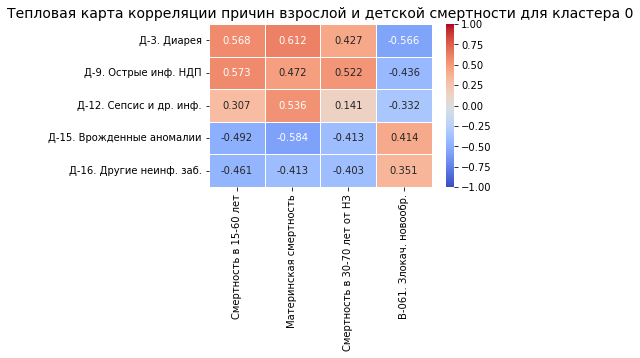

In [256]:
some_adult_mortality_features = [
    F.AdultMortality.value,
    F.MaternalMortality.value,
    F.AdultNcdMortality.value,
    F.AdultNcdMortality061.value,
]
some_child_mortality_features = [
    F.ChildUnder5Mortality3.value,
    F.ChildUnder5Mortality9.value,
    F.ChildUnder5Mortality12.value,
    F.ChildUnder5Mortality15.value,
    F.ChildUnder5Mortality16.value,
]
dislay_partial_correlation_matrix(
    cluster_0_data,
    columns_features=some_adult_mortality_features,
    rows_features=some_child_mortality_features,
    figsize=(5, 3),
    title='Тепловая карта корреляции причин взрослой и детской смертности для кластера 0',
)

Можно выделить положительную корреляцию материнской смертности с детской смертностью от инфекционных заболеваний
(наибольшая корреляция с диареей: 0.612).

Смертность взрослых от злокачественных новообразований положительно коррелирует с врожденными аномалиями.

### Корреляция для стран из кластера 1 (с менее благоприятными условиями и меньшей продолжительностью жизни)

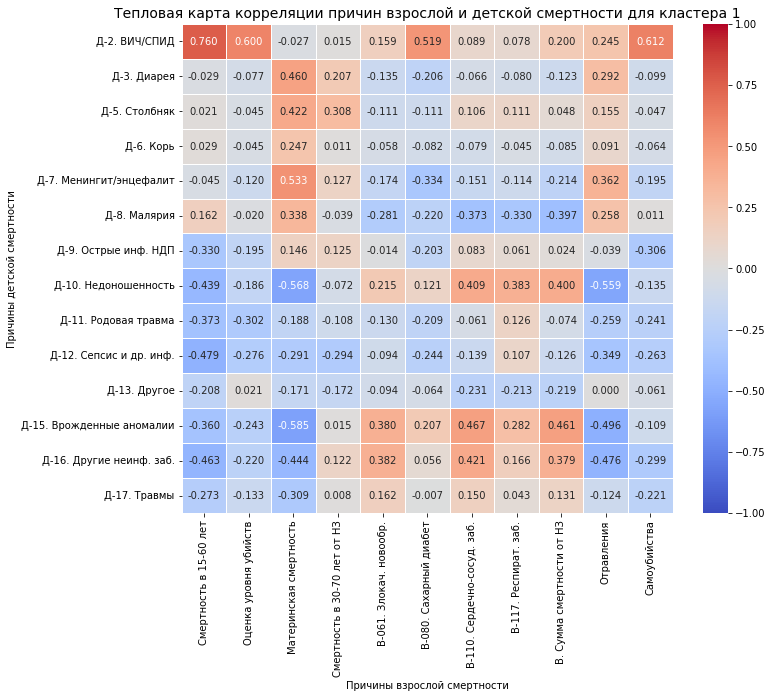

In [257]:
# Построим матрицу корреляции
dislay_partial_correlation_matrix(
    cluster_1_data, # данные стран из кластера 1
    columns_features=adult_mortality_fields, # столбцы с причинами взрослой смертности
    rows_features=child_mortality_fields, # строки с причинами детской смертности
    figsize=(11, 9),
    xlabel='Причины взрослой смертности',
    ylabel='Причины детской смертности',
    title='Тепловая карта корреляции причин взрослой и детской смертности для кластера 1',
)

Для наглядности оставим в таблице признаки с наибольшей корреляцией.

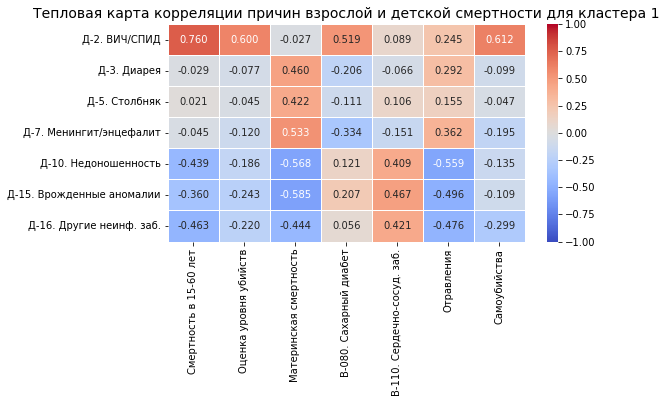

In [258]:
some_adult_mortality_features = [
    F.AdultMortality.value,
    F.Homicides.value,
    F.MaternalMortality.value,
    F.AdultNcdMortality080.value,
    F.AdultNcdMortality110.value,
    F.PoisoningMortality.value,
    F.SuicideMortality.value,
]
some_child_mortality_features = [
    F.ChildUnder5Mortality2.value,
    F.ChildUnder5Mortality3.value,
    F.ChildUnder5Mortality5.value,
    F.ChildUnder5Mortality7.value,
    F.ChildUnder5Mortality10.value,
    F.ChildUnder5Mortality15.value,
    F.ChildUnder5Mortality16.value,
]
dislay_partial_correlation_matrix(
    cluster_1_data,
    columns_features=some_adult_mortality_features,
    rows_features=some_child_mortality_features,
    figsize=(8, 4),
    title='Тепловая карта корреляции причин взрослой и детской смертности для кластера 1',
)

Можно заметить, что:

Детская смертность от ВИЧ/CПИД положительно коррелирует со следующими причинами взрослой смертности:
- Смертность в возрасте от 15 до 60 лет
- Убийства, самоубийства и сахарный диабет

Можно предположить, что если ВИЧ/CПИД есть среди детей, то он закономерно есть среди взрослых.\
Данных по заболеваемости взрослых найти, к сожалению, не удалось.\
Заболеваемость взрослых ВИЧ/CПИД ведет к более ранней смерти от разный причин, в том числе от сахарного диабета.\
Также в странах, где выше процент заболеваемости ВИЧ/CПИД скорее всего неблагоприятная социальная обстановка, что обычно сочетается с более высоким процентом убийств и самоубийств.

Материнская смертность положительно коррелирует с
- причинами детской смертности от диареи, столбняка, менингита/энцефалита.

Можно предположить, что частые случаи детской смертности от этих заболеваний связаны с недостаточно хорошо организованной мед. помощью. А с этим фактором скорее всего сочетается и материнская смертность.

## Выводы

- В странах **кластера 0** выше показатели детской и взрослой смертности от неинфекционных заболеваний.\
Причинами детской смертности преимущественно являются врожденные аномалии и недоношенность.

- В странах **кластера 1** выше показатели материнской смертности и отравлений, а также детской смертности от инфекционных заболеваний.\
Самыми частыми причинами детской смертности являются острые инфекции нижних дыхательных путей, недоношенность, родовая травма и диарея.\
Детская смертность от ВИЧ/CПИД положительно коррелирует со следующими факторами взрослой смертности:
    - Смертность в возрасте от 15 до 60 лет
    - Убийства, самоубийства и сахарный диабет

Для **обоих кластеров**:
- Среди неинфекционных заболеваний самая частая причина смертности - от сердечно-сосудистых заболеваний.
- Материнская смертность положительно коррелирует с детской смертностью от инфекционных заболеваний.